In [1]:
!pip install tensorflow_addons
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import PIL

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

dataset, _ = tfds.load("cycle_gan/vangogh2photo", with_info=True, as_supervised=True)
trainA, trainB = dataset["trainA"], dataset["trainB"]
testA, testB = dataset["testA"], dataset["testB"]
#image_count = glob.glob('/home/prashu/PycharmProjects/tenserflow/generative-local/data/**/*/*.jpg')
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
input_img_size=[256,256,3]
buffer_size = 256
batch_size = 1

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def preprocess_train_image(img, label):
    # Random flip
    print(img.shape)
    img = tf.image.random_flip_left_right(img)
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img

def preprocess_test_image(img, label):
    img = normalize_img(img)
    return img


# Apply the preprocessing operations to the training data
trainA = (
    trainA.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
trainB = (
    trainB.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
# Apply the preprocessing operations to the test data
testA = (
    testA.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
testB = (
    testB.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
#visualising
'''
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(trainA.take(4), trainB.take(4))):
    apple = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    orange = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()
'''

class ReflectionPadding2D(layers.Layer):
    

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")
def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_AB = get_resnet_generator(name="generator_AB")
gen_BA = get_resnet_generator(name="generator_BA")

# Get the discriminators
disc_A = get_discriminator(name="discriminator_A")
disc_B = get_discriminator(name="discriminator_B")

#the cyclegan model
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_AB,
        generator_BA,
        discriminator_A,
        discriminator_B,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_AB = generator_AB
        self.gen_BA = generator_BA
        self.disc_A = discriminator_A
        self.disc_B = discriminator_B
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_AB_optimizer,
        gen_BA_optimizer,
        disc_A_optimizer,
        disc_B_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_AB_optimizer = gen_AB_optimizer
        self.gen_BA_optimizer = gen_BA_optimizer
        self.disc_A_optimizer = disc_A_optimizer
        self.disc_B_optimizer = disc_B_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is apples and y is orange
        real_A, real_B = batch_data

        with tf.GradientTape(persistent=True) as tape:

            fake_A = self.gen_AB(real_A, training=True)
            fake_B = self.gen_BA(real_B, training=True)


            cycled_A = self.gen_AB(fake_A, training=True)
            cycled_B = self.gen_BA(fake_B, training=True)

            # Identity mapping
            same_A = self.gen_BA(real_A, training=True)
            same_B = self.gen_AB(real_B, training=True)

            # Discriminator output
            disc_real_A = self.disc_A(real_A, training=True)
            disc_fake_A = self.disc_A(fake_A, training=True)

            disc_real_B = self.disc_B(real_B, training=True)
            disc_fake_B = self.disc_B(fake_B, training=True)

            # Generator adverserial loss
            gen_AB_loss = self.generator_loss_fn(disc_fake_B)
            gen_BA_loss = self.generator_loss_fn(disc_fake_A)

            # Generator cycle loss
            cycle_loss_AB = self.cycle_loss_fn(real_B, cycled_B) * self.lambda_cycle
            cycle_loss_BA = self.cycle_loss_fn(real_A, cycled_A) * self.lambda_cycle

            # Generator identity loss
            id_loss_AB = (
                self.identity_loss_fn(real_B, same_B)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_BA = (
                self.identity_loss_fn(real_A, same_A)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_AB = gen_AB_loss + cycle_loss_AB + id_loss_AB
            total_loss_BA = gen_BA_loss + cycle_loss_BA + id_loss_BA

            # Discriminator loss
            disc_A_loss = self.discriminator_loss_fn(disc_real_A, disc_fake_A)
            disc_B_loss = self.discriminator_loss_fn(disc_real_B, disc_fake_B)

        # Get the gradients for the generators
        grads_AB = tape.gradient(total_loss_AB, self.gen_AB.trainable_variables)
        grads_BA = tape.gradient(total_loss_BA, self.gen_BA.trainable_variables)

        # Get the gradients for the discriminators
        disc_A_grads = tape.gradient(disc_A_loss, self.disc_A.trainable_variables)
        disc_B_grads = tape.gradient(disc_B_loss, self.disc_B.trainable_variables)

        # Update the weights of the generators
        self.gen_AB_optimizer.apply_gradients(
            zip(grads_AB, self.gen_AB.trainable_variables)
        )
        self.gen_BA_optimizer.apply_gradients(
            zip(grads_BA, self.gen_BA.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_A_optimizer.apply_gradients(
            zip(disc_A_grads, self.disc_A.trainable_variables)
        )
        self.disc_B_optimizer.apply_gradients(
            zip(disc_B_grads, self.disc_B.trainable_variables)
        )

        return {
            "G_loss": total_loss_AB,
            "F_loss": total_loss_BA,
            "D_X_loss": disc_A_loss,
            "D_Y_loss": disc_B_loss,
        }

#callback to monitor and produce outputs
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(testB.take(self.num_img)):
            prediction = self.model.gen_BA(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_AB=gen_AB, generator_BA=gen_BA, discriminator_A=disc_A, discriminator_B=disc_B
)

# Compile the model
cycle_gan_model.compile(
    gen_AB_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_BA_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_A_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_B_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

gen_BA.load_weights('/content/drive/MyDrive/gen_ba_1')
gen_AB.load_weights('/content/drive/MyDrive/gen_ab_1')
disc_A.load_weights('/content/drive/MyDrive/disc_a_1')
disc_B.load_weights('/content/drive/MyDrive/disc_b_1')

cycle_gan_model.fit(
    tf.data.Dataset.zip((trainA, trainB)),
    epochs=20,
    callbacks=[plotter],
)

gen_AB.save_weights('gen_ab_40')
gen_BA.save_weights('gen_ba_40')
disc_A.save_weights('disc_a_40')
disc_B.save_weights('disc_b_40')



Output hidden; open in https://colab.research.google.com to view.

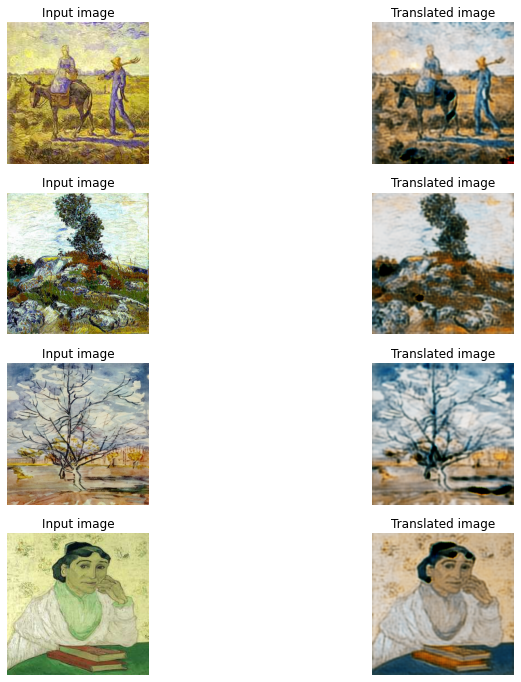

In [4]:

_, ax = plt.subplots(4, 2, figsize=(12, 12))
for i, img in enumerate(testA.take(4)):
    prediction = gen_AB(img)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")